In [1]:
%load_ext autoreload
%autoreload 1

%aimport utils
import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import display, HTML
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

## Parameter Setup For this Notebook

In [2]:
# Looped Countries
countries = ['USA', 'Europe', 'JPN']

# Use `train_months` as training sets to predict the next `predict_months`
train_months = 120
predict_months = 12

# A set of hyper-parameters for the LightGBM to randomSearchCV
params_space = {
    "max_depth": [1, 3, 5, 10, 15],
    "n_estimators": [50, 100, 300, 500],
    "bagging_fraction":[0.7, 0.85, 1]
}

# A set of threshold that will be applied to predict_probla
threshes = [0., 0.3, 0.5, 0.7]

# Output Locations
plot_location = os.path.abspath(
    os.path.join(os.getcwd(), '..', 'Plots', 'ML_Results'))
prediction_location = os.path.join(os.getcwd(), 'cache')

## Main Scripts

In [3]:
def load_data(country: str) -> pd.DataFrame:
    with open(os.path.join(os.getcwd(), 'cache', '%s.pickle' % country), 'rb') as f:
        data = pickle.load(f)

    display(HTML('<h4>%s - Features</h4>' % country))
    display(data['X'].head(3))

    display(HTML('<h4>%s - Labels</h4>' % country))
    display(data['Y'].head(3))

    display(HTML('<h4>%s - Label Names</h4>' % country))
    print(data['Y_Names'])
    display(HTML('<hr>'))
    
    return data


def make_predictions(data: pd.DataFrame,
                     train_months: int = train_months,
                     predict_months: int = predict_months,
                     params_space: Dict = params_space) -> Tuple:
    X = data['X'].shift(1).dropna()
    Y = data['Y'].iloc[:, 1:]
    
    rolling = utils.RollingMethod(rolling_bars=train_months,
                                  predict_bars=predict_months)
    model = utils.LightGBM(params_space=params_space)
    
    # Get predictions and predict_probla per class
    return rolling.run(model, data['X'], data['Y'])


def plot_performance(preds: pd.DataFrame, pred_probla: pd.DataFrame,
                     data: Dict, po: utils.PortfolioOptimizer, country: str,
                     threshes: List[float] = [0, 0.3, 0.5, 0.7]):
    
    fig, ax = plt.subplots(1,1,figsize=(16,8))

    for thresh, color in zip(threshes, sns.color_palette("Greens")[::-1]):
        ret = po.get_ret_from_ind_probla(preds, pred_probla, data['Y_Names'], thresh)
        ax.plot(np.log(ret + 1).cumsum(), label='Thresh %.2f' % thresh,
                color=color)

    ax.plot(np.log(po.market[ret.index] + 1).cumsum(), label='Mkt', alpha=0.7,
            lw=3, color=utils.COLOR_MAPPER['MKT'])
    ax.plot(np.log(po.portfolios['equal_weights'][ret.index] + 1).cumsum(),
            label='Equal Weights', lw=3, color=utils.COLOR_MAPPER['equal'])
    
    ax.set_title('<%s> Modeling Returns' % country, fontsize=14,
                  fontweight=700)
    ax.legend()
    return fig

,cpi,production,gvnbond10y,3mlibor,unemployment,cpi_diff,production_diff,gvnbond10y_diff,3mlibor_diff,unemployment_diff,QUA,MKT,SMB,HMLFF,HMLDE,UMD,RF,RV30D
DATE,,,,,,,,,,,,,,,,,,
1986-02-01,46.283600,52.5120,8.70,8.0625,7.2,-0.084382,-0.2635,-0.49,0.0625,0.5,0.004053,0.008433,-0.006213,-0.004894,-0.007060,0.002824,0.000279,0.007384
1986-03-01,46.030454,52.3399,7.78,7.8750,7.2,-0.253146,-0.1721,-0.92,-0.1875,0.0,0.000701,-0.003919,0.006875,-0.000649,-0.000400,0.005087,0.000281,0.005911
1986-04-01,45.861689,52.4317,7.30,7.3125,7.1,-0.168764,0.0918,-0.48,-0.5625,-0.1,0.005295,-0.012067,0.007298,0.002114,0.000776,0.003653,0.000254,0.006581


,labels
DATE,
1986-02-01,5
1986-03-01,4
1986-04-01,1


['equal_weights', 'main_QUA', 'main_SMB', 'main_HMLFF', 'main_UMD', 'MKT_MKT']


,labels
DATE,
1996-02-01,5.0
1996-03-01,5.0
1996-04-01,4.0


,0,1,2,3,4,5
DATE,,,,,,
1996-02-01,0.022937,0.281724,0.062005,0.129750,0.089442,0.414142
1996-03-01,0.013396,0.168043,0.122103,0.086416,0.140789,0.469252
1996-04-01,0.014028,0.226604,0.021052,0.139348,0.327629,0.271340


,Thresh,Accuracy,Percentage
0,0.0,0.239130,1.000000
1,0.3,0.246753,0.836957
2,0.5,0.239583,0.347826
3,0.8,0.200000,0.108696


,Thresh,Accuracy,Percentage
1,0.3,0.246753,0.836957
2,0.5,0.239583,0.347826
0,0.0,0.239130,1.000000
3,0.8,0.200000,0.108696


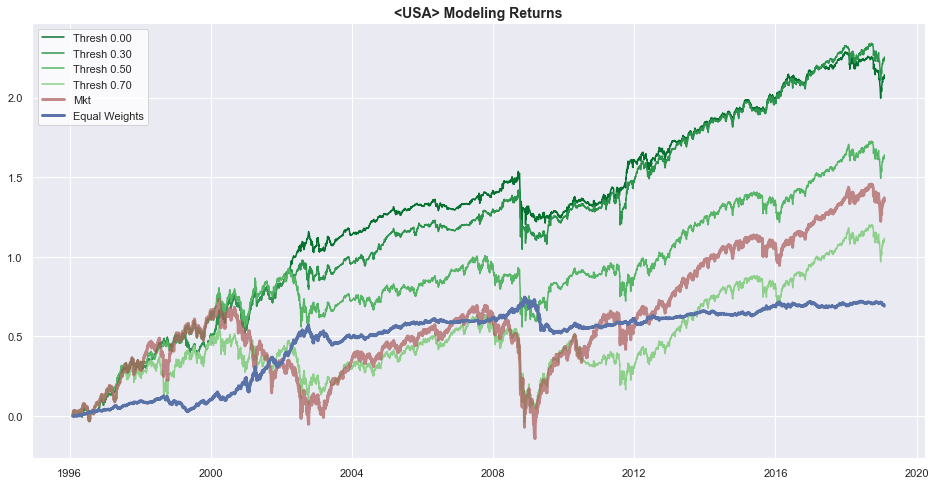

,cpi,production,gvnbond10y,3mlibor,unemployment,cpi_diff,production_diff,gvnbond10y_diff,3mlibor_diff,unemployment_diff,QUA,MKT,SMB,HMLFF,HMLDE,UMD,RF,RV30D
DATE,,,,,,,,,,,,,,,,,,
1999-02-01,73.72,86.5,3.9742,3.08063,10.1,0.16,-1.4,0.1522,-0.14062,-0.1,-0.004096,0.009529,-0.007339,-0.001328,-0.001236,-0.002616,0.000175,0.011914
1999-03-01,73.97,86.7,4.1810,3.10000,10.1,0.25,0.2,0.2068,0.01937,0.0,0.001275,-0.013931,0.010401,0.001200,0.000220,-0.000441,0.000182,0.007671
1999-04-01,74.23,87.2,4.0407,2.93688,10.0,0.26,0.5,-0.1403,-0.16312,-0.1,-0.000477,0.000073,-0.001061,-0.005542,-0.003251,0.005544,0.000175,0.008283


,labels
DATE,
1999-02-01,1
1999-03-01,3
1999-04-01,3


['equal_weights', 'main_QUA', 'main_SMB', 'main_HMLFF', 'main_UMD', 'MKT_MKT']


,labels
DATE,
2009-02-01,1.0
2009-03-01,3.0
2009-04-01,3.0


,0,1,2,3,4,5
DATE,,,,,,
2009-02-01,0.000005,0.645826,0.000026,0.315628,0.000579,0.037936
2009-03-01,0.000019,0.105708,0.000324,0.684050,0.011356,0.198543
2009-04-01,0.000002,0.001494,0.000768,0.942434,0.000157,0.055145


,Thresh,Accuracy,Percentage
0,0.0,0.254237,1.000000
1,0.3,0.263636,0.932203
2,0.5,0.296875,0.542373
3,0.8,0.266667,0.127119


,Thresh,Accuracy,Percentage
2,0.5,0.296875,0.542373
3,0.8,0.266667,0.127119
1,0.3,0.263636,0.932203
0,0.0,0.254237,1.000000


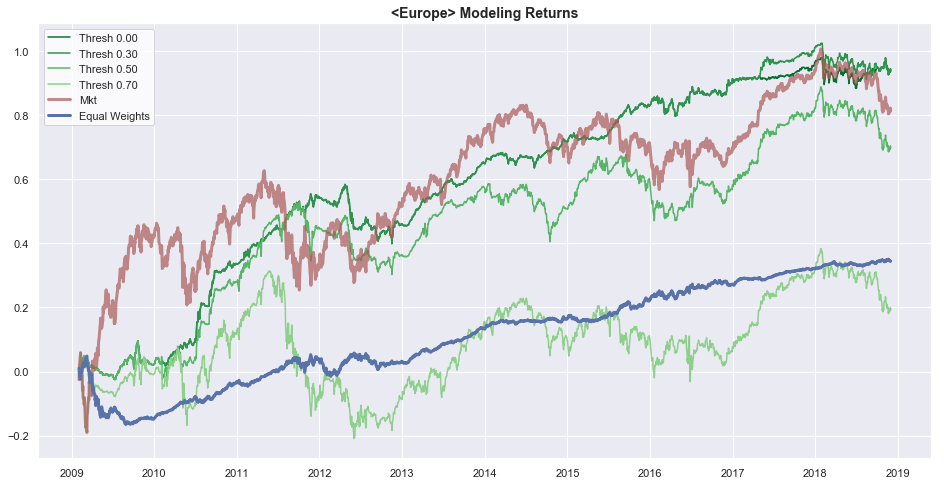

,cpi,production,gvnbond10y,3mlibor,unemployment,cpi_diff,production_diff,gvnbond10y_diff,3mlibor_diff,unemployment_diff,QUA,MKT,SMB,HMLFF,HMLDE,UMD,RF,RV30D
DATE,,,,,,,,,,,,,,,,,,
1993-07-01,97.4,98.968398,4.517,3.31250,2.5,0.3,0.512259,-0.319,0.00000,0.0,-0.000611,0.005474,-0.006782,0.003491,0.002053,-0.001152,0.000121,0.017454
1993-08-01,97.6,98.148784,4.407,3.25000,2.5,0.2,-0.819614,-0.110,-0.06250,0.0,-0.002104,0.001301,0.004588,-0.001838,-0.001340,0.003559,0.000121,0.011997
1993-09-01,97.7,98.046332,4.016,2.76563,2.6,0.1,-0.102452,-0.391,-0.48437,0.1,0.004059,-0.010524,0.001163,0.003849,0.000389,0.001486,0.000120,0.010801


,labels
DATE,
1993-07-01,5
1993-08-01,5
1993-09-01,1


['equal_weights', 'main_QUA', 'main_SMB', 'main_HMLFF', 'main_UMD', 'MKT_MKT']


,labels
DATE,
2003-07-01,4.0
2003-08-01,5.0
2003-09-01,5.0


,0,1,2,3,4,5
DATE,,,,,,
2003-07-01,0.045945,0.175084,0.040688,0.217688,0.331144,0.189450
2003-08-01,0.039699,0.112612,0.038137,0.124004,0.261449,0.424100
2003-09-01,0.052495,0.281393,0.033460,0.174321,0.053463,0.404868


,Thresh,Accuracy,Percentage
0,0.0,0.22043,1.000000
1,0.3,0.24000,0.806452
2,0.5,0.30000,0.268817
3,0.8,0.31250,0.086022


,Thresh,Accuracy,Percentage
3,0.8,0.31250,0.086022
2,0.5,0.30000,0.268817
1,0.3,0.24000,0.806452
0,0.0,0.22043,1.000000


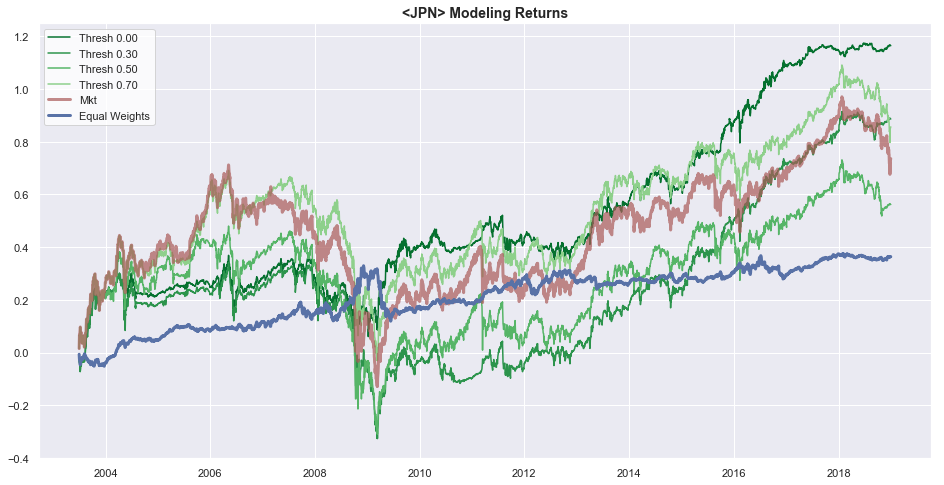

In [4]:
for country in countries:
    # =========================================================================
    #                               Load Data
    # =========================================================================
    display(HTML('<h2><span style="color:red">[%s]</span> Load Features/Labels '
                 'from Cached Data' % country))
    data = load_data(country)

    # =========================================================================
    #                               Run Model
    # =========================================================================
    # Make Predictions
    display(HTML('<h2><span style="color:red">[%s]</span> Model Predictions'
                 % country))
    preds, pred_probla, models = make_predictions(data)
    display(HTML('<h4>Label Prediction</h4>'))
    display(preds.dropna().head(3))
    display(HTML('<h4>Probability</h4>'))
    display(pred_probla.dropna().head(3))

    # =========================================================================
    #                            Check Accuracy
    # =========================================================================
    # Threshold Analysis
    display(HTML('<h2><span style="color:red">[%s]</span> Threshold Analysis'
                 % country))
    aqr = utils.load_aqr_data(country).dropna()
    po = utils.PortfolioOptimizer(
        utils.build_portfolio(aqr),
        aqr['RF'],
        aqr['MKT'],
        country
    )
    po.get_stats_table()
    po.get_best_indicators()
    display(HTML('<h4>Without Thresholding</h4>'))
    display(po.get_accuracy_performance_from_ind_probla(
        preds, pred_probla, data['Y_Names']))

    display(HTML('<h4>Top Thresholding</h4>'))
    display(po.get_accuracy_performance_from_ind_probla(
        preds, pred_probla, data['Y_Names']).sort_values(
            'Accuracy', ascending=False).head(5))

    # =========================================================================
    #                            Plot Cum Returns
    # =========================================================================
    display(HTML('<h2><span style="color:red">[%s]</span> Portfolio Returns'
                 % country))
    fig = plot_performance(preds, pred_probla, data, po, country,
                           threshes=threshes)
    plt.show()
    fig.savefig(os.path.join(plot_location, '%s_returns_t%d_p%d.pdf'
                             % (country, train_months, predict_months)),
                bbox_inches='tight')

    # =========================================================================
    #                       Cache Returns For Further Analysis
    # =========================================================================
    pred_cache = {
        'preds': preds,
        'probla': pred_probla,
        'labels': data['Y_Names'],
        'returns_equal': po.portfolios['equal_weights'],
        'returns_mkt': po.portfolios['MKT_MKT'],
        'models': models
    }
    for thresh in threshes:
        pred_cache['returns_' + str(thresh)] = po.get_ret_from_ind_probla(
            preds, pred_probla, data['Y_Names'], thresh)

    with open(os.path.join(prediction_location, '%s_preds_t%d_p%d.pickle'
                           % (country, train_months, predict_months)), 'wb') as f:
        pickle.dump(pred_cache, f)